In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [2]:
# device = torch.device("cuda:1")
device = torch.device("cpu")

## 1D regression dataset

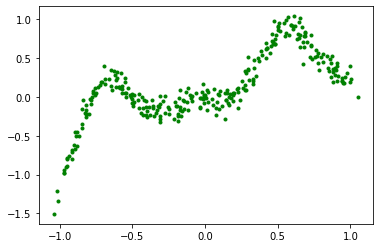

In [3]:
class Dataset2Dregression:
    def __init__(self):
        np.random.seed(12)
        x = np.linspace(0,1,300)
        noise = np.random.normal(0,0.02, x.shape)
        x = x + noise
        x = np.sort(x)

        y= (2 * np.sin(10*x) + np.cos(20 * x - 3) + 3 * np.log(10*x + 0.5) - 4)/6.
        noise = np.random.normal(0,0.1, x.shape)
        y = y + noise

        x = x*2
        x = x - x.mean() # good practice to zero-center x in linear mapping
        self.xx = torch.Tensor(x.reshape(-1,1))
        self.yy = torch.Tensor(y.reshape(-1,1))
        self.xy = torch.cat([self.xx, self.yy], dim=-1)
        pass
        
    def sample(self, n):
        assert n <= len(self.xx)
        rand_idx = torch.randperm(len(self.xx))[:n]
        
        return self.xy[rand_idx]

dataset = Dataset2Dregression()
x, y = dataset.xy[:,0], dataset.xy[:,1]

%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.show()

### Fit x, y - data with Normalizing Flow

In [116]:
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm
import nflib.res_flow as irf
import nflib

import torch.distributions as D

In [87]:
# class GaussianMixtureModel(torch.nn.Module):

#     def __init__(self, n_components: int=2):
#         super().__init__()
#         weights = torch.ones(n_components, )
#         means   = torch.randn(n_components, )
#         stdevs  = torch.tensor(np.abs(np.random.randn(n_components, )))
#         self.weights = torch.nn.Parameter(weights)
#         self.means   = torch.nn.Parameter(means)
#         self.stdevs  = torch.nn.Parameter(stdevs)
        
#     def log_prob(self, x):
#         mix  = D.Categorical(self.weights)
        
# #         comp = D.Normal(self.means, self.stdevs)
#         ### remove issue of negative std and exploding std.
#         std_weight = 1e-4
#         comp = D.Normal(self.means, std_weight * self.stdevs.abs())

#         gmm  = D.MixtureSameFamily(mix, comp)
#         return gmm.log_prob(x)

In [88]:
# from gmm_ssl import SSLGaussMixture

In [89]:
prior = MultivariateNormal(torch.zeros(2), torch.eye(2))
# prior = GaussianMixtureModel(2)
# prior = SSLGaussMixture(torch.zeros(15, 2))

flows = []
hidden_dims = [20,20]

for i in range(3): ## N layers
    a = irf.ResidualFlow(2, hidden_dims, activation=irf.Swish, scaler=0.97, reverse=False)
    b = ActNorm(2)
    flows += [b, a]

model = NormalizingFlow(flows, prior)

In [90]:
# dir(prior)

In [91]:
model

NormalizingFlow(
  (flow): SequentialFlow(
    (flows): ModuleList(
      (0): ActNorm()
      (1): ResidualFlow(
        (resblock): ModuleList(
          (0): Linear(in_features=2, out_features=20, bias=True)
          (1): Swish()
          (2): Linear(in_features=20, out_features=20, bias=True)
          (3): Swish()
          (4): Linear(in_features=20, out_features=2, bias=True)
        )
      )
      (2): ActNorm()
      (3): ResidualFlow(
        (resblock): ModuleList(
          (0): Linear(in_features=2, out_features=20, bias=True)
          (1): Swish()
          (2): Linear(in_features=20, out_features=20, bias=True)
          (3): Swish()
          (4): Linear(in_features=20, out_features=2, bias=True)
        )
      )
      (4): ActNorm()
      (5): ResidualFlow(
        (resblock): ModuleList(
          (0): Linear(in_features=2, out_features=20, bias=True)
          (1): Swish()
          (2): Linear(in_features=20, out_features=20, bias=True)
          (3): Swish()
 

## Model Train

In [92]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0) # todo tune WD
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  1584


In [93]:
x = dataset.sample(128)

### Model has parameters: input(x), logDetJ=False, intermediate=False
model(x, True, False)

(tensor([[ 1.3633,  1.7957],
         [-1.4301, -1.8513],
         [ 1.3062,  1.6961],
         [ 1.2717,  2.0737],
         [ 0.1464, -0.3793],
         [ 1.3718,  1.3782],
         [-0.7404, -0.0900],
         [-0.1007, -0.4246],
         [-0.0060, -0.4241],
         [-1.1194,  0.3448],
         [-0.0251, -0.2139],
         [ 0.5466,  0.0298],
         [-0.1706, -0.2018],
         [ 1.7794,  0.5906],
         [-1.2699, -0.5843],
         [ 1.7951,  0.8502],
         [-1.2882, -0.3272],
         [-0.8012, -0.0822],
         [-0.3345, -0.7952],
         [ 0.7781,  0.7953],
         [-1.3898, -1.1425],
         [-0.1004, -0.3460],
         [ 0.8131,  1.0690],
         [ 0.4704,  0.0802],
         [ 0.6662,  0.6918],
         [-0.4693, -0.1515],
         [-1.1370,  0.2668],
         [ 0.3496, -0.1978],
         [ 0.9823,  1.5257],
         [-1.3143, -0.8823],
         [-0.0338,  0.2135],
         [-0.1141, -0.7719],
         [-0.8149,  0.0406],
         [-0.7234, -0.1291],
         [ 0.2

In [94]:
model.train()
losses = []
for k in tqdm(range(1000*5+1)):
    x = dataset.sample(300)
    
    z, logDetJ, prior_logP = model(x, True)
    loss = -torch.mean(prior_logP + logDetJ) # NLL
    
    model.zero_grad()
    loss.backward()
    optimizer.step()

    if k % 1000 == 0:
        losses.append(loss.item())
        print(k, losses[-1])
        print(logDetJ.data.max(), logDetJ.data.min())

  0%|          | 12/5001 [00:00<01:23, 59.75it/s]

0 1.486603856086731
tensor(1.4515) tensor(1.3293)


 20%|██        | 1009/5001 [00:15<00:58, 68.12it/s]

1000 0.23223143815994263
tensor(4.3251) tensor(0.6747)


 40%|████      | 2012/5001 [00:30<00:43, 68.83it/s]

2000 -0.0008834600448608398
tensor(4.6928) tensor(0.4723)


 60%|██████    | 3006/5001 [00:46<00:36, 55.17it/s]

3000 -0.1561279445886612
tensor(4.5484) tensor(0.5770)


 80%|████████  | 4009/5001 [01:01<00:14, 69.01it/s]

4000 -0.2383098304271698
tensor(4.5344) tensor(0.9571)


100%|██████████| 5001/5001 [01:18<00:00, 63.92it/s]

5000 -0.2635304629802704
tensor(4.7021) tensor(1.3879)


tensor(-0.2098, grad_fn=<NegBackward>)


Text(0.5, 1.0, 'z -> x')

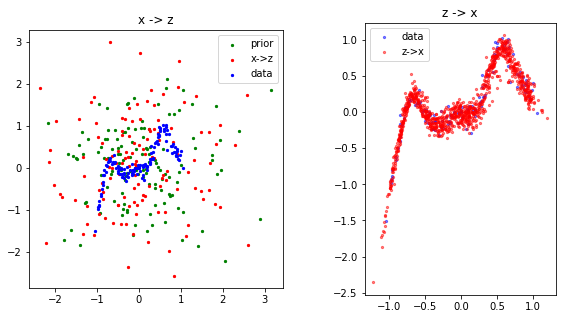

In [95]:
model.eval()

x = dataset.sample(128)
z, logDetJ, prior_logP = model(x, True)
print(-torch.mean(prior_logP + logDetJ))

x = x.detach().numpy()
z = z.detach().numpy()
p = model.prior.sample((128,))
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.scatter(z[:,0], z[:,1], c='r', s=5)
plt.scatter(x[:,0], x[:,1], c='b', s=5)
plt.legend(['prior', 'x->z', 'data'])
plt.axis('scaled')
plt.title('x -> z')

z = model.sample(128*8)
z = z.detach().numpy()
plt.subplot(122)
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
plt.legend(['data', 'z->x'])
plt.axis('scaled')
plt.title('z -> x')

## Fit the gaussians 

In [280]:
from sklearn.mixture import GaussianMixture

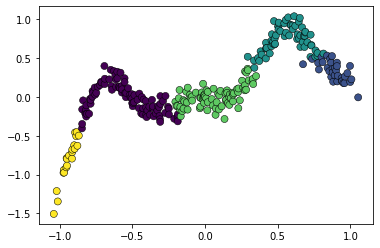

In [281]:
gmm = GaussianMixture(
    n_components=5,
    covariance_type = 'spherical', ## Must be one of ‘spherical’, ‘tied’, ‘diag’, ‘full’
)
gmmc = gmm.fit_predict(dataset.xy)

x, y = dataset.xy[:,0], dataset.xy[:,1]
plt.scatter(x, y, c=gmmc, s=50, edgecolors='k', lw=0.5)

In [282]:
def plot_results(X, Y_, means, covariances_, covariance_type, alpha=0.2, covar_scale = [0.5, 1, 2] ):
    ax = plt.subplot(1, 1, 1)
    
    N = len(means)
    for i, mean in enumerate(means):
        
        if covariance_type == "full":
            covar = covariances_[i][:N, :N]
        elif covariance_type == "tied":
            covar = covariances_[:N, :N]
        elif covariance_type == "diag":
            covar = np.diag(covariances_[i][:N])
        elif covariance_type == "spherical":
            covar = np.eye(means.shape[1]) * covariances_[i]

        
        v, w = np.linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        sctp = plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], marker='.')

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        c = sctp.get_facecolor()[0]
    
        for scale in covar_scale:
            ell = matplotlib.patches.Ellipse(mean, v[0]*scale, v[1]*scale, 180. + angle, color=c)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(alpha/scale)
            ax.add_artist(ell)

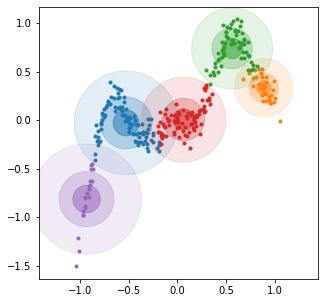

In [283]:
plt.figure(figsize=(5,5))
plot_results(dataset.xy, gmmc, gmm.means_, gmm.covariances_, gmm.covariance_type, alpha=0.25)
plt.axis('equal');

## Find the outputs given the inputs

In [284]:
gmm.weights_

array([0.32654636, 0.11395363, 0.21211033, 0.27770405, 0.06968563])

In [285]:
# gmm.weights_ = np.ones_like(gmm.weights_)

In [286]:
gmm.means_

array([[-0.52973418, -0.02729268],
       [ 0.88978005,  0.333485  ],
       [ 0.56288847,  0.73934431],
       [ 0.06296472,  0.00730485],
       [-0.93693512, -0.81272547]])

In [287]:
gmm.covariances_

array([0.03573561, 0.01129838, 0.02182956, 0.02381339, 0.04019227])

(array([26., 45., 34., 44., 27., 32., 29., 32., 19., 12.]),
 array([6.02143176e-04, 1.81727402e-01, 3.62852661e-01, 5.43977919e-01,
        7.25103178e-01, 9.06228437e-01, 1.08735370e+00, 1.26847895e+00,
        1.44960421e+00, 1.63072947e+00, 1.81185473e+00]),
 <BarContainer object of 10 artists>)

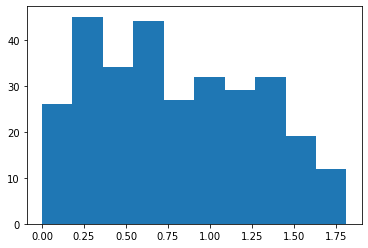

In [288]:
plt.hist(np.exp(gmm.score_samples(dataset.xy)))

(array([264.,  12.,   5.,   7.,   3.,   5.,   2.,   1.,   0.,   1.]),
 array([2.39726646e-67, 1.86633042e-01, 3.73266084e-01, 5.59899126e-01,
        7.46532168e-01, 9.33165211e-01, 1.11979825e+00, 1.30643129e+00,
        1.49306434e+00, 1.67969738e+00, 1.86633042e+00]),
 <BarContainer object of 10 artists>)

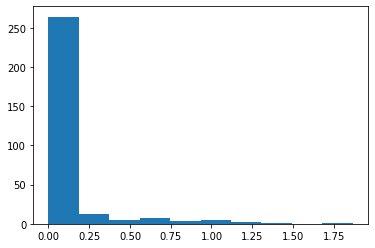

In [289]:
plt.hist(np.exp(gmm.score_samples(torch.randn_like(dataset.xy))))

#### Find the Y values given the differentiable function

In [466]:
# class GaussianMixture_Spherical(torch.nn.Module):

#     def __init__(self, dim, n_components: int=2):
#         super().__init__()
#         self.dim = dim
#         weight = torch.ones(1, n_components)
#         mean = torch.randn(n_components, dim)
#         log_std = torch.zeros(1, n_components)
        
#         self.weight = torch.nn.Parameter(weight)
#         self.mean = torch.nn.Parameter(mean)
#         self.log_std = torch.nn.Parameter(log_std)
#         pass
    
#     def set_parameters_from_sklearn(self, mean, covar, weight):
#         self.mean.data = torch.Tensor(mean)
#         self.log_std.data = torch.Tensor(np.log(covar)/2).reshape(1, -1)
#         self.weight.data = torch.Tensor(weight).reshape(1, -1)
#         pass
        
#     def forward(self, x):
#         std = torch.exp(self.log_std)
  
#         ### OPTION 1: use cdist
# #         x = torch.cdist(x, self.mean, p=2)*std
        
#         ### OPTION 2: use scaling the diffs
#         z = x.unsqueeze(1) - self.mean.unsqueeze(0)
# #         z = z / (std.unsqueeze(-1)**2)
# #         x = torch.norm(z, p=2, dim=-1)
#         x = torch.matmul(z.unsqueeze(-2), z.unsqueeze(-1)).squeeze(-1).squeeze(-1)
# #         print(x.shape)
#         print(x)
        
#         x = torch.exp(-0.5*x**2) * 1/(std * np.sqrt((2*np.pi)**self.dim))
# #         x = x * self.weight
#         return x

In [468]:
myGMM.set_parameters_from_sklearn(gmm.means_, gmm.covariances_, gmm.weights_)

In [469]:
probs = myGMM(dataset.xy)

tensor([[ 1918.9294, 55743.6719, 15987.6895,  6193.0410,   304.9073],
        [ 1288.3884, 47324.7891, 13257.8936,  4695.2847,   103.1140],
        [ 1545.9100, 50495.6797, 14346.0781,  5276.1719,   179.8857],
        ...,
        [ 1867.2513,   248.9016,  1026.3770,  1604.6570,  2944.8740],
        [ 1899.8517,   197.0848,   965.5260,  1656.5648,  3008.1294],
        [ 1962.8940,  1109.0107,  1668.5978,  1730.0122,  2855.6965]],
       grad_fn=<SqueezeBackward1>)


In [463]:
probs

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], grad_fn=<DivBackward0>)

In [464]:
# probs.sum(dim=-1)

In [465]:
gmm.predict_proba(dataset.xy)

array([[3.10661247e-012, 4.60923346e-134, 4.21062129e-073,
        2.91472463e-029, 1.00000000e+000],
       [4.20760746e-009, 3.60939812e-115, 6.35341754e-062,
        2.80757814e-023, 9.99999996e-001],
       [1.97575646e-010, 2.80525243e-122, 2.06446015e-066,
        1.30195131e-025, 1.00000000e+000],
       ...,
       [1.19703591e-014, 9.99946374e-001, 5.36017341e-005,
        2.37675346e-008, 1.39354473e-026],
       [4.98881157e-015, 9.99922279e-001, 7.77119214e-005,
        9.55939600e-009, 2.91681686e-027],
       [2.79351889e-013, 9.99993072e-001, 6.23919186e-006,
        6.88642896e-007, 1.07808777e-023]])

In [446]:
np.exp(gmm.score_samples(dataset.xy))

array([6.02143176e-04, 3.47439112e-02, 7.42750384e-03, 1.94286948e-01,
       2.21910207e-01, 1.96481245e-01, 2.46221933e-01, 2.73178940e-01,
       2.74487052e-01, 2.58004818e-01, 2.64673836e-01, 2.73368077e-01,
       2.41357866e-01, 2.19870827e-01, 1.74267729e-01, 2.09286037e-01,
       7.31106430e-02, 9.23615722e-02, 7.31594589e-02, 1.75271981e-01,
       8.91845227e-02, 7.97328734e-02, 1.02263671e-01, 2.81896004e-01,
       3.78198634e-01, 2.70584333e-01, 3.34298470e-01, 2.74176514e-01,
       2.27833064e-01, 4.15830236e-01, 2.82980905e-01, 3.23850275e-01,
       5.53436565e-01, 5.43101309e-01, 5.72624121e-01, 6.13363833e-01,
       5.41910066e-01, 5.87466518e-01, 5.10441189e-01, 6.77360829e-01,
       6.79228549e-01, 5.56860608e-01, 5.46107705e-01, 4.51778014e-01,
       4.77538277e-01, 7.88288438e-02, 5.98773402e-01, 3.88150124e-01,
       4.67318049e-01, 1.63095704e-01, 8.17660168e-01, 1.00073608e+00,
       2.06606407e-01, 3.38624328e-01, 5.45497551e-01, 9.40048222e-01,
      

In [386]:
myGMM(torch.randn(30, 2)).sum(dim=-1)

tensor([0.0000e+00, 1.0749e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.7015e-16, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.2951e-25, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.9433e-41, 0.0000e+00, 6.4880e-43],
       grad_fn=<SumBackward1>)

## GMM Torch

In [19]:
from gmm_torch import GaussianMixture

In [20]:
gmmt = GaussianMixture(5, 2, covariance_type="full")

In [21]:
gmmt.fit(dataset.xy, n_iter=1000)

In [22]:
torch.exp(gmmt.score_samples(dataset.xy)).mean()

tensor(1.4198)

In [23]:
gmmt.score_samples(dataset.xy)

tensor([-3.3327e+00, -5.9994e-01, -2.1634e+00,  2.6540e-01,  2.1547e-01,
         3.3787e-01,  5.3734e-01, -1.9432e-02,  1.9816e-01,  5.9224e-01,
         6.2367e-01,  3.2779e-01,  9.3052e-01,  9.5428e-01,  1.0456e+00,
         8.1434e-01, -1.5215e-01,  9.6173e-01,  6.1088e-01,  2.2907e-01,
         1.0754e+00,  9.7972e-01,  1.1457e+00, -1.2470e+00, -3.8954e+00,
         9.9655e-01,  8.8397e-01,  1.0393e+00,  9.2152e-01,  3.5807e-01,
         9.4825e-01,  1.2884e-01,  6.4653e-01,  7.5449e-01,  7.8329e-01,
         6.8720e-01,  3.6420e-01,  5.7604e-01,  3.8963e-01,  1.0987e-01,
        -1.5374e-01, -5.9612e-02, -7.2928e-01, -4.9995e-01, -7.1924e-01,
        -2.7034e-01, -9.5403e-01, -2.3823e-01,  2.0117e-01, -8.8056e-01,
         5.5943e-02, -4.1917e-01, -9.0791e-01, -1.9506e-01,  4.3807e-01,
         5.7314e-01, -1.1898e+00,  2.3411e-01,  8.0389e-01,  8.3211e-01,
         8.3882e-01, -1.4640e+00,  8.7244e-01,  7.2714e-01,  9.2830e-01,
        -5.6590e-01,  2.9462e-01,  9.7070e-01,  6.4

In [24]:
torch.exp(gmmt.score_samples(torch.randn_like(dataset.xy))).mean()

tensor(0.1315)

In [25]:
# gmm.predict_proba(dataset.xy)

### Optimize for best Y given the X

In [36]:
x = dataset.xy[:,:1]
# y = torch.autograd.Variable(torch.zeros_like(x), requires_grad=True)
y = torch.autograd.Variable(torch.randn_like(x)*0.3, requires_grad=True)

In [37]:
xy = torch.cat([x, y], dim=-1)
xy.requires_grad

True

In [38]:
optimizer = optim.Adam([y], lr=0.001)

In [44]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(1000):
    xy = torch.cat([x, y], dim=-1)
    error = -torch.exp(gmmt.score_samples(xy)).mean()
    optimizer.zero_grad()
    error.backward(retain_graph=True)
    optimizer.step()
    
    if i%100 == 0:
        print(f"Step: {i}, E: {error:.6f}")
        
        ax.clear()
        ax.scatter(x, y.data, marker='.', color='r')
        ax.scatter(dataset.xy[:,0], dataset.xy[:,1], marker='.', color='g')

        fig.canvas.draw()
        plt.pause(0.01)
plt.close()

Step: 0, E: -1.526675
Step: 100, E: -1.526675
Step: 200, E: -1.526675
Step: 300, E: -1.526675
Step: 400, E: -1.530996
Step: 500, E: -1.531901
Step: 600, E: -1.531901
Step: 700, E: -1.531901
Step: 800, E: -1.531901
Step: 900, E: -1.531901


In [45]:
y.grad

tensor([[ 1.7104e-14],
        [-4.4994e-12],
        [-1.2715e-13],
        [ 1.4688e-13],
        [-1.7864e-11],
        [-4.7668e-08],
        [-2.7671e-11],
        [-1.5582e-13],
        [ 4.8530e-11],
        [ 1.5032e-13],
        [ 4.2210e-08],
        [ 1.6084e-08],
        [ 1.6163e-08],
        [-4.3536e-10],
        [ 1.2559e-08],
        [ 4.6030e-25],
        [ 8.3788e-25],
        [-3.1710e-08],
        [-2.8736e-10],
        [ 1.6842e-23],
        [-4.9258e-10],
        [ 8.8673e-09],
        [-1.3269e-08],
        [ 2.3283e-10],
        [ 2.8294e-10],
        [-1.0502e-08],
        [ 7.9529e-09],
        [-4.4793e-09],
        [-1.3139e-08],
        [-9.2350e-09],
        [ 2.3799e-12],
        [ 1.1111e-08],
        [-4.3378e-09],
        [ 1.9914e-08],
        [ 7.5588e-10],
        [-7.2648e-09],
        [-5.5744e-05],
        [ 1.5862e-08],
        [-3.4915e-08],
        [ 8.7645e-09],
        [ 1.6248e-08],
        [-3.3182e-12],
        [ 1.1514e-12],
        [ 4

In [46]:
# %matplotlib inline
# plt.scatter(x, y, marker='.', color='g')
# plt.scatter(x, YY.data, marker='.', color='r')
# plt.show()